# **Analysis of results**

## **Libraries**

In [1]:
#%pip install pandas matplotlib seaborn

In [2]:
import os
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import constants

## **Directories**

(Change the log file to automatically make new directories and plots).

In [3]:
RESULTS_FOLDER = constants.RESULTS_DATA_FOLDER
INSPECTED_FOLDER = constants.INSPECTED_DATA_FOLDER

CHECKPOINTS_100_LOG_FILENAME = 'split_tok_150_checkpoint_100.log' #'dev_checkpoint_100.log'
CHECKPOINT_100_LOG_FILEPATH = os.path.join(INSPECTED_FOLDER, CHECKPOINTS_100_LOG_FILENAME)
CHECKPOINTS_100_RESULTS_FOLDER = os.path.join(RESULTS_FOLDER, 'checkpoints_100')
CURRENT_RESULTS_FOLDER = os.path.join(CHECKPOINTS_100_RESULTS_FOLDER, CHECKPOINTS_100_LOG_FILENAME.split('.')[0])

if not os.path.exists(CHECKPOINTS_100_RESULTS_FOLDER):
    os.makedirs(CHECKPOINTS_100_RESULTS_FOLDER)

if not os.path.exists(CURRENT_RESULTS_FOLDER):
    os.makedirs(CURRENT_RESULTS_FOLDER)

## **Log format**

### **Log parsing**

In [4]:
log_lines = []
with open(CHECKPOINT_100_LOG_FILEPATH, 'r') as f:
    log_lines = f.readlines()

In [5]:
log_lines[-60:-50]

['[2023-05-31 15:30:59] [valid] References contain unknown word, metric scores may be inaccurate\n',
 "[2023-05-31 15:30:59] [valid] First sentence's tokens as scored:\n",
 '[2023-05-31 15:30:59] [valid] DefaultVocab keeps original segments for scoring\n',
 '[2023-05-31 15:30:59] [valid]   Hyp: De acuerdo a los datos relacionados con el cambio de declaraciÃ³n acerca de todos los niÃ±os y jÃ³venes son las siguientes tÃ©cnicas a pesar de cÃ³mo se vieron afectados asÃ\xad como uno de los no participaron en lo que va de acuerdo a lo que va a lo tanto es el titular de lo referente es la diferencia de todos los tales como presidente general y dijeron que es posible lo que le dieron a pesar de lo referente es los damnificados por el presidente de la DirecciÃ³n de Estado tras la supervisiÃ³n de lo largo es un largo particular y no cuenta con lo referente a las largo general y dijo a pesar de la apertura del presidente de la DirecciÃ³n Nacional Central para la Entidad de TrÃ¡nsito\n',
 '[2023-0

The format of log files is: 

```[DATE] [valid] Ep. <METRIC_0> : <VALUE_0> ... <METRIC_n> : <VALUE_n> : (stalled n times|new best)\n```

In [6]:
log_regex = r'''
    \[(\d{4})-(\d{2})-(\d{2})\s(\d{2}):(\d{2}):(\d{2})\]\s
    \[valid\]\s
    Ep\.\s(\S+)\s:\s
    Up\.\s(\S+)\s
    (?::\s(\S+)\s:\s(\S+))+\s
    :\s(.+)
'''
log_regex = re.compile(log_regex, re.VERBOSE)

In [7]:
def parse_line_groups(lines, regex):
    # type: (list[str], re.Pattern) -> list[tuple[str, str, str, str, str, str]]
    line_groups = []

    for line in lines:
        match = regex.match(line)
        if match:
            line_groups.append(match.groups()) 

    return line_groups   

In [8]:
lines = parse_line_groups(log_lines, log_regex)
[' '.join(lines for lines in line_group) for line_group in lines[30:35]]

['2023 05 31 14 18 28 61 17795 bleu 1.02891 stalled 2 times (last best: 1.06916)',
 '2023 05 31 14 21 23 61 17795 chrf 21.9157 new best',
 '2023 05 31 14 21 30 61 17795 cross-entropy 153.585 stalled 6 times (last best: 105.698)',
 '2023 05 31 14 21 37 61 17795 perplexity 1286.35 stalled 6 times (last best: 137.998)',
 '2023 05 31 14 21 40 61 17795 valid-script 0 stalled 6 times (last best: 0)']

### **Convert log to dataframe**

In [9]:
def create_log_dataframe(parsed_lines, debug=False):
    # type: (list[tuple[str, str, str, str, str, str]], bool) -> pd.DataFrame
    log_by_epoch = dict()
    seen_epochs = set()
    static_columns = ['index', 'epoch', 'year', 'month', 'day', 'hour', 'minute', 'second', 'update', 'status']
    for column in static_columns:
        log_by_epoch[column] = []

    for idx, line in enumerate(parsed_lines):
        year, month, day,\
        hour, minute, second,\
        epoch, update,\
        metric, metric_value,\
        status = line

        static_values_to_append = [idx, epoch, year, month, day, hour, minute, second, update, status]

        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            for column, value in zip(static_columns, static_values_to_append):
                log_by_epoch[column].append(value)

        if metric not in log_by_epoch:
            log_by_epoch[metric] = []
        log_by_epoch[metric].append(metric_value)

    if debug:
        print('seen epochs: {}'.format(seen_epochs))
    
    return pd.DataFrame(log_by_epoch)

In [10]:
log_dataframe = create_log_dataframe(lines)

In [11]:
log_dataframe

,index,epoch,year,month,day,hour,minute,second,update,status,bleu,chrf,cross-entropy,perplexity,valid-script
0,0,11,2023,05,31,12,56,16,2968,new best,0.753966,15.0711,105.698,137.998,0
1,5,21,2023,05,31,13,11,28,5933,new best,0.919478,18.0336,108.136,154.614,0
2,10,31,2023,05,31,13,26,37,8898,stalled 1 times (last best: 0.919478),0.90243,19.5935,119.262,259.706,0
3,15,34,2023,05,31,13,36,06,10000,new best,0.984389,19.9284,120.927,280.676,0
4,20,41,2023,05,31,13,47,44,11864,new best,1.06917,20.7317,127.924,388.92,0
5,25,51,2023,05,31,14,03,03,14829,stalled 1 times (last best: 1.06916),1.04739,21.4614,140.878,711.38,0
6,30,61,2023,05,31,14,18,28,17795,stalled 2 times (last best: 1.06916),1.02891,21.9157,153.585,1286.35,0
7,35,68,2023,05,31,14,31,38,20000,stalled 3 times (last best: 1.06916),1.06849,21.9648,161.991,1903.47,0
8,40,71,2023,05,31,14,39,55,20760,stalled 4 times (last best: 1.06916),1.02775,22.1685,164.904,2180.33,0
9,45,81,2023,05,31,14,55,20,23727,new best,1.06932,22.1634,176.965,3825.54,0


In [12]:
log_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          19 non-null     int64 
 1   epoch          19 non-null     object
 2   year           19 non-null     object
 3   month          19 non-null     object
 4   day            19 non-null     object
 5   hour           19 non-null     object
 6   minute         19 non-null     object
 7   second         19 non-null     object
 8   update         19 non-null     object
 9   status         19 non-null     object
 10  bleu           19 non-null     object
 11  chrf           19 non-null     object
 12  cross-entropy  19 non-null     object
 13  perplexity     19 non-null     object
 14  valid-script   19 non-null     object
dtypes: int64(1), object(14)
memory usage: 2.4+ KB


<font color='orange'>*Obs:* All the columns have object Dtype</font>

In [13]:
categorical_columns = ['status']
numerical_columns = [col for col in log_dataframe.columns if col not in categorical_columns]
log_dataframe[numerical_columns] = log_dataframe[numerical_columns].astype(float)

In [14]:
log_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          19 non-null     float64
 1   epoch          19 non-null     float64
 2   year           19 non-null     float64
 3   month          19 non-null     float64
 4   day            19 non-null     float64
 5   hour           19 non-null     float64
 6   minute         19 non-null     float64
 7   second         19 non-null     float64
 8   update         19 non-null     float64
 9   status         19 non-null     object 
 10  bleu           19 non-null     float64
 11  chrf           19 non-null     float64
 12  cross-entropy  19 non-null     float64
 13  perplexity     19 non-null     float64
 14  valid-script   19 non-null     float64
dtypes: float64(14), object(1)
memory usage: 2.4+ KB


In [15]:
inspected_filename = CHECKPOINTS_100_LOG_FILENAME.split('.')[0]
log_dataframe.to_csv(os.path.join(CURRENT_RESULTS_FOLDER, CHECKPOINTS_100_LOG_FILENAME + '_log_dataframe.csv'))

## **Log analysis**

### **Metrics**

In [77]:
def plot_metrics_by_epoch(dataframe, metrics, save_path=None):
    num_metrics = len(metrics)
    
    sns.set(style='darkgrid')
    fig, axes = plt.subplots(ncols=num_metrics, figsize=(4*num_metrics, 4))
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.lineplot(x='epoch', y=metric, data=dataframe, ax=ax)
        ax.set_title(metric)

        highest_value = dataframe[metric].max()
        max_index = dataframe[dataframe[metric] == highest_value]['epoch'].values[0]
        ax.plot(max_index, highest_value, marker='o', markersize=8, color='red')
        ax.text(0, highest_value, f'Epoch: {int(max_index-1)} \n Max: {highest_value:.2f}', ha='center', va='bottom', color='black', bbox=dict(facecolor='white', alpha=1, edgecolor='black'))
    
    plt.tight_layout()
    plt.savefig(save_path) if save_path is not None else plt.show()

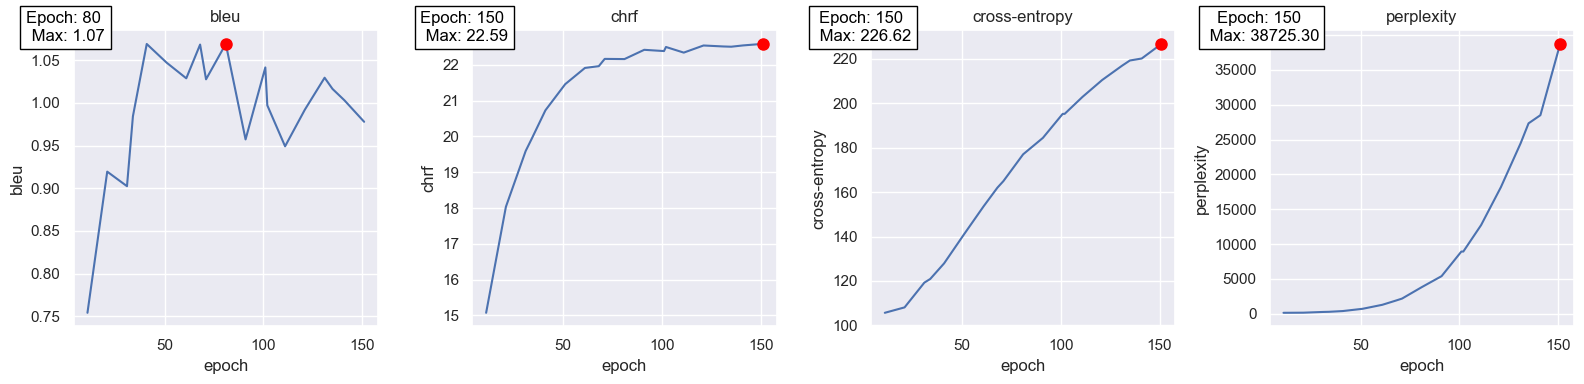

In [78]:
metrics = ['bleu', 'chrf', 'cross-entropy', 'perplexity']
save_path = os.path.join(CURRENT_RESULTS_FOLDER, CHECKPOINTS_100_LOG_FILENAME + '_metrics.png')
plot_metrics_by_epoch(log_dataframe, metrics, save_path=save_path)

In [40]:
log_dataframe.describe()

,index,epoch,year,month,day,hour,minute,second,update,bleu,chrf,cross-entropy,perplexity,valid-script,time_diff,time_diff_sec
count,19.000000,19.000000,19.0,19.0,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,18,18.000000
mean,45.000000,81.789474,2023.0,5.0,31.0,14.421053,30.894737,32.000000,23995.894737,0.991369,21.336226,171.084316,9698.752316,0.0,0 days 00:13:21.222222222,801.222222
std,28.136572,43.284048,0.0,0.0,0.0,1.261207,17.188157,16.792856,12841.774366,0.075039,1.966058,41.118829,11961.074512,0.0,0 days 00:02:51.479566800,171.479567
min,0.000000,11.000000,2023.0,5.0,31.0,12.000000,3.000000,3.000000,2968.000000,0.753966,15.071100,105.698000,137.998000,0.0,0 days 00:07:19,439.000000
25%,22.500000,46.000000,2023.0,5.0,31.0,13.500000,18.500000,20.000000,13346.500000,0.967606,21.096550,134.401000,550.150000,0.0,0 days 00:10:59.750000,659.750000
50%,45.000000,81.000000,2023.0,5.0,31.0,14.000000,31.000000,31.000000,23727.000000,1.003190,22.168500,176.965000,3825.540000,0.0,0 days 00:15:10.500000,910.500000
75%,67.500000,116.000000,2023.0,5.0,31.0,15.500000,43.500000,46.500000,34110.500000,1.035630,22.505000,206.564000,15444.200000,0.0,0 days 00:15:28,928.000000
max,90.000000,151.000000,2023.0,5.0,31.0,16.000000,56.000000,57.000000,44493.000000,1.069320,22.588700,226.621000,38725.300000,0.0,0 days 00:15:41,941.000000


### **Time**

In [19]:
def add_time_diff(dataframe):
    # type: (pd.DataFrame) -> pd.DataFrame
    dataframe['datetime'] = pd.to_datetime(dataframe[['year', 'month', 'day', 'hour', 'minute', 'second']])
    dataframe['time_diff'] = dataframe['datetime'].diff()
    return dataframe

In [20]:
log_dataframe = add_time_diff(log_dataframe)

In [21]:
log_dataframe['time_diff']

0                NaT
1    0 days 00:15:12
2    0 days 00:15:09
3    0 days 00:09:29
4    0 days 00:11:38
5    0 days 00:15:19
6    0 days 00:15:25
7    0 days 00:13:10
8    0 days 00:08:17
9    0 days 00:15:25
10   0 days 00:15:33
11   0 days 00:15:38
12   0 days 00:07:19
13   0 days 00:14:30
14   0 days 00:15:29
15   0 days 00:15:36
16   0 days 00:10:45
17   0 days 00:10:47
18   0 days 00:15:41
Name: time_diff, dtype: timedelta64[ns]

In [22]:
log_dataframe['time_diff'].describe()

count                           18
mean     0 days 00:13:21.222222222
std      0 days 00:02:51.479566800
min                0 days 00:07:19
25%         0 days 00:10:59.750000
50%         0 days 00:15:10.500000
75%                0 days 00:15:28
max                0 days 00:15:41
Name: time_diff, dtype: object

In [99]:
def plot_time_diff(dataframe, index, value, save_path=None):
    sns.set(style='darkgrid')
    index = [int(i) for i in dataframe[index].values]
    sns.barplot(x=index, y=value, data=dataframe, palette='Blues_d')

    for index, row in dataframe.iterrows():
        text_value = str(row['time_diff']).split(' ')[-1]
        text_value = text_value.split(':')[1:]
        text_value = ':'.join(text_value)
        plt.text(index, row['time_diff_sec'], text_value, ha='center', va='bottom', fontsize=8)

    mean = dataframe['time_diff_sec'].mean()
    std = dataframe['time_diff_sec'].std()
    plt.axhline(mean, color='#FF8C00', linestyle='--', label='Mean')
    #plt.axhspan(mean - std, mean + std, facecolor='orange', alpha=0.3, label='Deviation')
    mean_text = '{}:{}'.format(int(mean) // 60, int(mean % 60))
    plt.text(0, mean, mean_text, ha='center', va='bottom')

    plt.xlabel('Index')
    plt.ylabel('Time Difference (seconds)')
    plt.title('Time Differences between Consecutive Tuples')
    plt.savefig(save_path) if save_path is not None else plt.show()

In [100]:
log_dataframe['time_diff_sec'] = log_dataframe['time_diff'].dt.total_seconds()

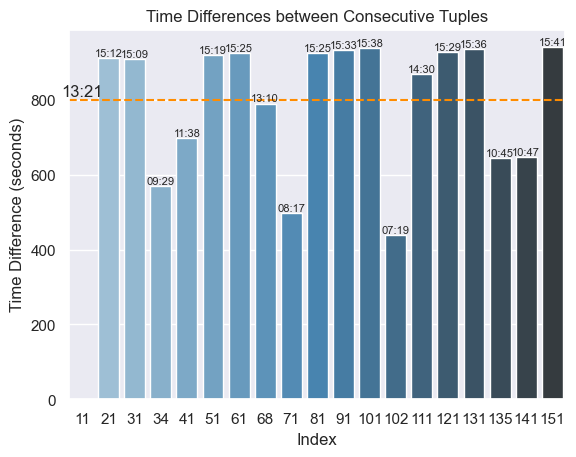

In [101]:
save_path = os.path.join(CURRENT_RESULTS_FOLDER, CHECKPOINTS_100_LOG_FILENAME + '_time_diff.png')
plot_time_diff(log_dataframe, 'epoch', 'time_diff_sec', save_path=save_path)

<font color='orange'>*Obs:* There are 3 outliers that shouldn't be there...</font>

### **Time taken by metrics**

In [102]:
log_time_regex = r'''
    \[(\d{4})-(\d{2})-(\d{2})\s(\d{2}):(\d{2}):(\d{2})\]\s
    \[valid\]\s
    (.+)
'''

log_time_regex = re.compile(log_time_regex, re.VERBOSE)

In [103]:
time_lines = parse_line_groups(log_lines, log_time_regex)

In [104]:
' '.join(time_lines[0])

'2023 05 31 12 53 25 References contain unknown word, metric scores may be inaccurate'

In [105]:
def create_log_metric_dataframe(parsed_lines, debug=False):
    # type: (list[tuple[str, str, str, str, str, str]], bool) -> pd.DataFrame
    log = dict()
    static_columns = ['index', 'year', 'month', 'day', 'hour', 'minute', 'second', 'rest']
    for column in static_columns:
        log[column] = []

    for idx, line in enumerate(parsed_lines):
        static_values_to_append = [idx, *line]
        for column, value in zip(static_columns, static_values_to_append):
            log[column].append(value)

    if debug:
        print('seen epochs: {}'.format(log))
    
    return pd.DataFrame(log)

In [106]:
log_metric_dataframe = create_log_metric_dataframe(time_lines)

In [107]:
log_metric_dataframe.head()

,index,year,month,day,hour,minute,second,rest
0,0,2023,05,31,12,53,25,"References contain unknown word, metric scores..."
1,1,2023,05,31,12,53,25,First sentence's tokens as scored:
2,2,2023,05,31,12,53,25,DefaultVocab keeps original segments for scoring
3,3,2023,05,31,12,53,25,Hyp: En el marco de la ciudadanÃ­a en el mar...
4,4,2023,05,31,12,53,25,Ref: <unk> importante citar que los daÃ±os <...


In [108]:
log_metric_dataframe = add_time_diff(log_metric_dataframe)

In [109]:
log_metric_dataframe.tail()

,index,year,month,day,hour,minute,second,rest,datetime,time_diff
165,165,2023,05,31,16,56,38,Ep. 151 : Up. 44493 : bleu : 0.977939 : stalle...,2023-05-31 16:56:38,0 days 00:02:53
166,166,2023,05,31,16,59,30,Ep. 151 : Up. 44493 : chrf : 22.5887 : new best,2023-05-31 16:59:30,0 days 00:02:52
167,167,2023,05,31,16,59,37,Ep. 151 : Up. 44493 : cross-entropy : 226.621 ...,2023-05-31 16:59:37,0 days 00:00:07
168,168,2023,05,31,16,59,44,Ep. 151 : Up. 44493 : perplexity : 38725.3 : s...,2023-05-31 16:59:44,0 days 00:00:07
169,169,2023,05,31,16,59,47,Ep. 151 : Up. 44493 : valid-script : 0 : stall...,2023-05-31 16:59:47,0 days 00:00:03


In [110]:
def create_metric_time_dataframe(dataframe, metrics, debug=False):
    # type: (pd.DataFrame, list[str], bool) -> pd.DataFrame
    metric_time_dataframe = {}
    for idx, row in dataframe.iterrows():
        for metric in metrics:
            if metric in row['rest']:
                metric_time_dataframe.setdefault(metric, [])
                metric_time_dataframe[metric].append(row['time_diff'])

    if debug:
        print('metric time dataframe: {}'.format(metric_time_dataframe))

    return pd.DataFrame(metric_time_dataframe)

In [111]:
time_metric_df = create_metric_time_dataframe(log_metric_dataframe, metrics)

In [112]:
time_metric_df.tail()

,bleu,chrf,cross-entropy,perplexity
14,0 days 00:02:49,0 days 00:02:55,0 days 00:00:08,0 days 00:00:08
15,0 days 00:02:54,0 days 00:02:55,0 days 00:00:07,0 days 00:00:07
16,0 days 00:02:50,0 days 00:02:56,0 days 00:00:07,0 days 00:00:07
17,0 days 00:07:34,0 days 00:02:56,0 days 00:00:07,0 days 00:00:07
18,0 days 00:02:53,0 days 00:02:52,0 days 00:00:07,0 days 00:00:07


In [113]:
time_metric_df.describe()

,bleu,chrf,cross-entropy,perplexity
count,19,19,19,19
mean,0 days 00:03:57.473684210,0 days 00:02:54.473684210,0 days 00:00:06.947368421,0 days 00:00:06.789473684
std,0 days 00:02:25.918306071,0 days 00:00:02.756173294,0 days 00:00:00.404651319,0 days 00:00:00.535303379
min,0 days 00:02:49,0 days 00:02:50,0 days 00:00:06,0 days 00:00:06
25%,0 days 00:02:49,0 days 00:02:52,0 days 00:00:07,0 days 00:00:06.500000
50%,0 days 00:02:51,0 days 00:02:55,0 days 00:00:07,0 days 00:00:07
75%,0 days 00:02:55,0 days 00:02:56,0 days 00:00:07,0 days 00:00:07
max,0 days 00:11:13,0 days 00:03:00,0 days 00:00:08,0 days 00:00:08


In [114]:
save_path = os.path.join(CURRENT_RESULTS_FOLDER, CHECKPOINTS_100_LOG_FILENAME + '_time_by_metric.csv')
time_metric_df.to_csv(save_path)